In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import SGD 
import numpy as np
import matplotlib.pylab as plt

# Реализация "Ванильной" RNN
* Попробуем обучить сеть восстанавливать слово hello по первой букве. т.е. построим charecter-level модель

In [2]:
word = 'hello'

## Датасет. 
Позволяет:
* Закодировать символ при помощи one-hot
* Делать итератор по слову, которыей возвращает текущий символ и следующий как таргет

In [4]:
class WordDataSet:
    
    def __init__(self, word):
        self.chars2idx = {}
        self.indexs  = []
        for c in word: 
            if c not in self.chars2idx:
                self.chars2idx[c] = len(self.chars2idx)
                
            self.indexs.append(self.chars2idx[c])
            
        self.vec_size = len(self.chars2idx)
        self.seq_len  = len(word)
        
    def get_one_hot(self, idx):
        x = torch.zeros(self.vec_size)
        x[idx] = 1
        return x
    
    def __iter__(self):
        return zip(self.indexs[:-1], self.indexs[1:])
    
    def __len__(self):
        return self.seq_len
    
    def get_char_by_id(self, id):
        for c, i in self.chars2idx.items():
            if id == i: return c
        return None

## Реализация базовой RNN
<br/>
Скрытый элемент
$$ h_t= tanh⁡ (W_{ℎℎ} h_{t−1}+W_{xh} x_t) $$
Выход сети

$$ y_t = W_{hy} h_t $$

In [6]:
class VanillaRNN(nn.Module):
    
    def __init__(self, in_size=5, hidden_size=3, out_size=5):
        super(VanillaRNN, self).__init__()
        self.x2hidden    = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.hidden      = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.activation  = nn.Tanh()
        self.outweight   = nn.Linear(in_features=hidden_size, out_features=out_size)
    
    def forward(self, x, prev_hidden):
        hidden = self.x2hidden(x) + self.hidden(prev_hidden)
        output = self.outweight(hidden)
        return output, hidden

## Инициализация переменных 

In [21]:
ds = WordDataSet(word=word)
rnn = VanillaRNN(in_size=ds.vec_size, hidden_size=3, out_size=ds.vec_size)
criterion = nn.CrossEntropyLoss()
e_cnt     = 100
optim     = SGD(rnn.parameters(), lr = 0.1)

# Обучение

/home/asd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
/home/asd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


6.477231979370117
1.614551067352295
0.07363772392272949
0.025761127471923828
0.016772747039794922
0.012516498565673828
0.009969234466552734
0.00826120376586914
0.007034778594970703
0.006112575531005859


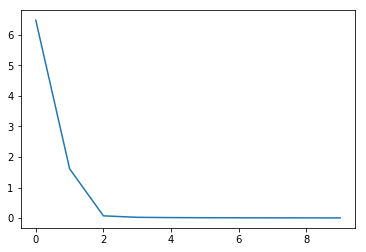

In [22]:
losses = []
for epoch in range(e_cnt):
    hh = Variable( torch.zeros(rnn.hidden.in_features) )
    loss = 0
    optim.zero_grad()
    for sample, next_sample in ds:
        x = Variable(  ds.get_one_hot(sample).unsqueeze(0) )
        target =  Variable(torch.LongTensor([next_sample]) )

        y, hh = rnn(x, hh)
        
        loss += criterion(y, target)
     
    if epoch % 10 == 0:
        print (loss.data[0].item())
        losses.append(loss.data[0].item())
    loss.backward()
    optim.step()
    
plt.plot(losses)

# Тестирование

In [14]:
rnn.eval()
hh = Variable( torch.zeros(rnn.hidden.in_features) )
id = 0
softmax = nn.Softmax()
predword =ds.get_char_by_id(id)
for c in enumerate(word[:-1]):
    x = Variable(ds.get_one_hot(id).unsqueeze(0))
    y, hh = rnn(x, hh)
    y = softmax(y)
    m, id = torch.max(y, 1)
    id = id.data[0]
    predword += ds.get_char_by_id(id)
print ('Prediction: ' , predword)

Prediction:  hello


/home/asd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
